In [1]:
# command = """/home/gridsan/shibal/.conda/envs/MOETF29/bin/python -u main_sparse_singletask_public_data.py --data 'madelon' --data_type 'classification' --load_directory /home/gridsan/shibal/public-datasets --seed 8 --sparsity 'GroupL0L2' --anneal --n_trials 10 --version 1 --tuning_seed 100 --loss 'cross-entropy' --use_passed_hyperparameters --batch_size_scaler 16 --constant_learning_rate 1.866427718120356 --num_trees 6 --depth 6 --epochs 500 --kernel_constraint 100 --kernel_l2 0.3753706487881207 --temperature 0.0485927674871322 --save_directory ./logs/soft_trees/publicdata
# """

In [2]:
# !{command}

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 5)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer


# Performance Comparison

# Group L0L2

In [6]:
data = 'arcene'
budget = 0.7
max_features = {
    'hypothyroid': 44,
#     'spambase': 57,
    'churn': 33,
    'twonorm': 20,
#     'optdigits': 108,
    'texture': 40,
    'satimage': 36,
    'isolet': 617,
    'mice-protein': 77,
#     'human-activity-recognition': 561,
#     'mnist': 784,
#     'fashion-mnist': 784,
#     'sleep': 154,
    'arcene': 10000,
    'gisette': 5000,
    'madelon': 500,
    'dorothea': 100000,
#     'basehock': 4862,
#     'pcmac': 3289,
#     'relathe': 4322,
    'smk': 19993,
    'cll': 11340,
    'gli': 22283,
    'lung': 3312,
    'prostrate': 5966,
    'tox': 5748
}

In [7]:
sparsities = ['GroupL0L2']
annealing = [True]
learning_rate_scheduling = [False]
# sparsities = ['GroupLasso','GroupL0L2']
# annealing = [False, False]
# learning_rate_scheduling = [False, False]
criteria = 'auc'
tuning_seeds = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
version = 20 # 8 # 18

for sparsity, anneal, lr_schedule in zip(sparsities, annealing, learning_rate_scheduling):
    print("=============Sparsity:{}, ======== Anneal:{} ====== LR Schedule:{}".format(sparsity, anneal, lr_schedule))

    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
        path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/{}.{}/study-shared-sigmoid-{}".format(data, sparsity, version, tuning_seed, sparsity)
        if anneal:
            path = path+"-anneal"
        if lr_schedule:
            path = path+"-learning_rate_scheduling"
#         path = path+"-seed8.csv"
        try:
            df_temp = pd.read_csv(path+"-seed8.csv")
        except:
            print("Missing:", path+"-seed8.csv")
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))
    print("Number of total trials:", df.shape[0])
    print("Max number of features:", max_features[data])
    df_study = df.copy()
    df = df[(df["user_attrs_feature_sparsity"]<=budget*max_features[data])&(df["user_attrs_feature_sparsity"]>0)]
    print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
    df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
    best_value = df["user_attrs_"+criteria+"_valid"].values[0]
    df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]

    df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
    if criteria=='auc':
        print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
        print("test_auc:", df_opt.user_attrs_auc_test.mean())
        print("test_aucs:", df_opt.user_attrs_auc_test.values)
    elif criteria=='accuracy':
        print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
        print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
        print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
    print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
    print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
#     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
#     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
#     print("Batch-sizes:", df_opt.params_constant_batch_size.values*df_opt.params_batch_size_scaler.values)
    print("Epochs:", df_opt.user_attrs_num_epochs.values)
    print("Depth:", df_opt.params_depth.values)
    print("Number of Trees:", df_opt.params_num_trees.values)
    print("LR:", df_opt.params_constant_learning_rate.values)
    if "params_kernel_constraint" in df_opt.columns:
        print("L1/L0:", df_opt.params_kernel_constraint.values)
    if "params_kernel_l2" in df_opt.columns:
        print("L2:", df_opt.params_kernel_l2.values)
    if "params_temperature" in df_opt.columns:
        print("T:", df_opt.params_temperature.values)
    if "params_batch_size_scaler" in df_opt.columns:
        print("Batch-sizes:", 16*df_opt.params_batch_size_scaler.values)
        
#     df = df[df["user_attrs_approximate_feature_sparsity"]<budget*df["user_attrs_approximate_feature_sparsity"].max()]
#     print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
#     df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
#     best_value = df["user_attrs_"+criteria+"_valid"].values[0]
#     df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]

#     df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
#     if criteria=='auc':
#         print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
#         print("test_auc:", df_opt.user_attrs_auc_test.mean())
#         print("test_aucs:", df_opt.user_attrs_auc_test.values)
#     elif criteria=='accuracy':
#         print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
#         print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
#         print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
#     print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
#     print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
# #     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
# #     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
# #     print("Batch-sizes:", df_opt.params_batch_size.values)
#     print("Depths:", df_opt.params_depth.values)
#     print("Epochs:", df_opt.user_attrs_num_epochs.values)
# #     print("Learning Rates:", df_opt.params_learning_rate.values)


=============Sparsity:GroupL0L2, ======== Anneal:True ====== LR Schedule:False
Missing: ./logs/soft_trees/publicdata/arcene/GroupL0L2/cross-entropy/20.0/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Missing: ./logs/soft_trees/publicdata/arcene/GroupL0L2/cross-entropy/20.11/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Missing: ./logs/soft_trees/publicdata/arcene/GroupL0L2/cross-entropy/20.12/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Missing: ./logs/soft_trees/publicdata/arcene/GroupL0L2/cross-entropy/20.13/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Missing: ./logs/soft_trees/publicdata/arcene/GroupL0L2/cross-entropy/20.14/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Missing: ./logs/soft_trees/publicdata/arcene/GroupL0L2/cross-entropy/20.15/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Missing: ./logs/soft_trees/publicdata/arcene/GroupL0L2/cross-entropy/20.16/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Missing: ./logs/soft_trees/publicdata/arcene/GroupL0L2/cross-

In [269]:
df_opt.columns

Index(['Unnamed: 0', 'number', 'value', 'datetime_start', 'datetime_complete',
       'duration', 'params_batch_size_scaler', 'params_constant_learning_rate',
       'params_depth', 'params_epochs', 'params_kernel_l2', 'params_num_trees',
       'params_temperature', 'user_attrs_accuracy_test',
       'user_attrs_accuracy_valid', 'user_attrs_approximate_feature_sparsity',
       'user_attrs_approximate_feature_sparsity_history',
       'user_attrs_approximate_weight_sparsity',
       'user_attrs_approximate_weight_sparsity_history', 'user_attrs_auc_test',
       'user_attrs_auc_valid', 'user_attrs_feature_sparsity',
       'user_attrs_feature_sparsity_history', 'user_attrs_num_epochs',
       'user_attrs_val_loss_history', 'user_attrs_weight_sparsity',
       'user_attrs_weight_sparsity_history', 'state'],
      dtype='object')

In [270]:
pd.set_option('display.max_rows', 100)

In [271]:
df_opt['params_kernel_constraint'] = 100

In [272]:
df_opt[[
    'params_batch_size_scaler',
    'params_constant_learning_rate',
    'params_num_trees',
    'params_depth',
#     'learning_rate_scheduling',
#     'group_sparsity',
#     'use_annealing',
    'user_attrs_num_epochs',
    'params_kernel_constraint',
    'params_kernel_l2',
#     'params_kernel_regularizer',
    'params_temperature'
]]


params_batch_size_scaler  params_constant_learning_rate   
1199                        16                       0.800809  \
796                          4                       2.584332   
1333                        16                       0.663658   
825                         64                       0.410365   

      params_num_trees  params_depth  user_attrs_num_epochs   
1199                 9             1                    990  \
796                  9             3                    790   
1333                90             1                    175   
825                 75             1                    735   

      params_kernel_constraint  params_kernel_l2  params_temperature  
1199                       100          0.089751            0.002367  
796                        100          0.029525            0.039632  
1333                       100          0.682980            0.026414  
825                        100          0.709227            0.005714

In [273]:
(2**(df_opt['params_depth'])*df_opt['params_num_trees'])

1199     18
796      72
1333    180
825     150
dtype: int64

In [275]:
i=0
f"--use_passed_hyperparameters --batch_size_scaler {df_opt['params_batch_size_scaler'].values[i]} --constant_learning_rate {df_opt['params_constant_learning_rate'].values[i]} --num_trees {df_opt['params_num_trees'].values[i]} --depth {df_opt['params_depth'].values[i]} --epochs {df_opt['user_attrs_num_epochs'].values[i]} --kernel_constraint {df_opt['params_kernel_constraint'].values[i]} --kernel_l2 {df_opt['params_kernel_l2'].values[i]} --temperature {df_opt['params_temperature'].values[i]}"


'--use_passed_hyperparameters --batch_size_scaler 16 --constant_learning_rate 0.800808776663843 --num_trees 9 --depth 1 --epochs 990 --kernel_constraint 100 --kernel_l2 0.0897507040394167 --temperature 0.0023672695420049'

In [276]:
df_opt['user_attrs_feature_sparsity_history'].values[2]

'[19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19993, 19992, 19989, 19985, 19977, 19949, 19916, 19852, 19728, 19537, 19248, 18834, 18264, 17468, 16493, 15408, 14483, 13248, 11933, 10552, 9451, 8389, 7960, 7573, 7481, 7451, 7423, 7381, 7323, 7198, 7028, 6801, 6507, 6160, 5786, 5373, 4996, 4520, 4071, 3678, 3308, 2988, 2664, 2393, 2137, 1930, 1726, 1550, 1407, 1272, 1157, 1032, 910, 823, 730, 655, 597, 535, 483, 439, 407, 363, 335, 316, 286, 269, 254, 244, 229, 215, 208, 201, 193, 185, 178, 173, 170, 170, 169, 168, 167, 167, 167, 167, 165, 165, 165, 164, 164, 162, 160, 160, 158, 156, 155, 154, 154, 154, 154, 154, 154, 153, 153, 153, 153, 152, 152, 152, 152, 151, 150, 147, 146, 145, 143, 143, 143, 143, 143, 143, 142, 141, 140, 140, 140, 138, 136, 136, 136, 136, 136, 135, 135, 134, 133, 133, 132, 132, 132, 132, 132, 132, 132, 129, 129

In [277]:
val_loss_history = [float(i) for i in df_opt['user_attrs_val_loss_history'].values[3][1:-1].split(', ')]
feature_sparsity_history = [float(i) for i in df_opt['user_attrs_feature_sparsity_history'].values[3][1:-1].split(', ')]

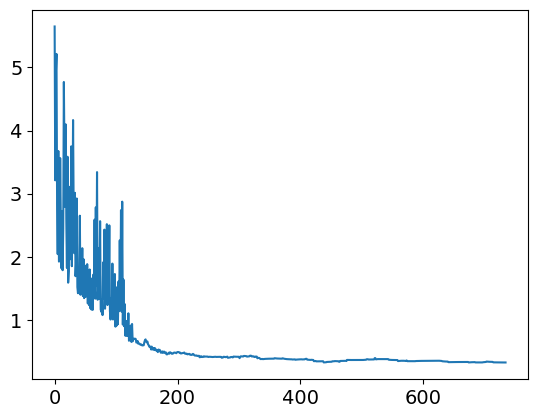

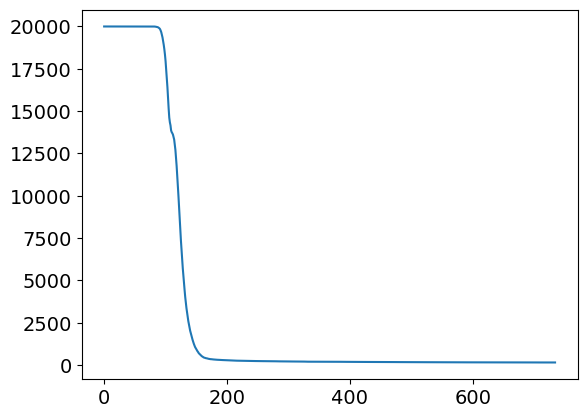

In [278]:
plt.plot(val_loss_history)
plt.show()

plt.plot(feature_sparsity_history)
# plt.ylim([0,2000])
plt.show()

In [67]:
# plt.scatter(np.log10(df['params_kernel_constraint']), df['user_attrs_feature_sparsity'], marker="*", color='b')
# plt.scatter(np.log10(df_opt["params_kernel_constraint"]), df_opt["user_attrs_feature_sparsity"], marker="o", color='r')

In [68]:
# plt.scatter(np.log10(df['params_kernel_l2']), df['user_attrs_feature_sparsity'], marker="*", color='b')
# plt.scatter(np.log10(df_opt["params_kernel_l2"]), df_opt["user_attrs_feature_sparsity"], marker="o", color='r')

In [1]:
data = 'isolet'
budget = 0.25
sparsities = ['Lasso']
annealing = [False]
learning_rate_scheduling = [False]
criteria = 'auc'
tuning_seeds = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for sparsity, anneal, lr_schedule in zip(sparsities, annealing, learning_rate_scheduling):
    print("=============Sparsity:{}, ======== Anneal:{} ====== LR Schedule:{}".format(sparsity, anneal, lr_schedule))

    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
        path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/5.{}/study-shared-sigmoid-100-5-{}".format(data, sparsity, tuning_seed, sparsity)
        if anneal:
            path = path+"-anneal"
        if lr_schedule:
            path = path+"-learning_rate_scheduling"
        path = path+"-seed8.csv"
        try:
            df_temp = pd.read_csv(path)
        except:
            print("Missing:", path)
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))
    print("Number of total trials:", df.shape[0])
    df = df[(df["user_attrs_feature_sparsity"]<=budget*df["user_attrs_feature_sparsity"].max())&(df["user_attrs_feature_sparsity"]>0)]
    print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
    df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
    
    best_value = df["user_attrs_"+criteria+"_valid"].values[0]
    df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]
    
    df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
    display(df_opt.T)
    if criteria=='auc':
        print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
        print("test_auc:", df_opt.user_attrs_auc_test.mean())
        print("test_aucs:", df_opt.user_attrs_auc_test.values)
        print("test_aucs (SE):", df_opt.user_attrs_auc_test.std()/np.sqrt(50))
    elif criteria=='accuracy':
        print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
        print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
        print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
    print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
    print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
    print("Standard Error sparsity:", df_opt.user_attrs_approximate_feature_sparsity.std()/np.sqrt(50))
#     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
#     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
    print("Batch-sizes:", df_opt.params_constant_batch_size.values*df_opt.params_batch_size_scaler.values)
    print("Epochs:", df_opt.user_attrs_num_epochs.values)
    print("Number of Trees:", df_opt.params_num_trees.values)
        
#     df = df[df["user_attrs_approximate_feature_sparsity"]<budget*df["user_attrs_approximate_feature_sparsity"].max()]
#     print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
#     df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
#     best_value = df["user_attrs_"+criteria+"_valid"].values[0]
#     df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]

#     df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
#     if criteria=='auc':
#         print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
#         print("test_auc:", df_opt.user_attrs_auc_test.mean())
#         print("test_aucs:", df_opt.user_attrs_auc_test.values)
#     elif criteria=='accuracy':
#         print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
#         print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
#         print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
#     print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
#     print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
# #     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
# #     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
# #     print("Batch-sizes:", df_opt.params_batch_size.values)
#     print("Depths:", df_opt.params_depth.values)
#     print("Epochs:", df_opt.user_attrs_num_epochs.values)
# #     print("Learning Rates:", df_opt.params_learning_rate.values)


=============Sparsity:Lasso, ======== Anneal:False ====== LR Schedule:False


NameError: name 'pd' is not defined

In [ ]:
df[[col for col in df.columns if "params" in col]]

In [ ]:
plt.scatter(np.log10(df['params_temperature']), df['user_attrs_feature_sparsity'], marker="*", color='b')
plt.scatter(np.log10(df_opt["params_temperature"]), df_opt["user_attrs_feature_sparsity"], marker="o", color='r')

In [ ]:
df_sel = df[df["user_attrs_"+criteria+"_valid"]>0.80]
plt.scatter(df_sel["user_attrs_"+criteria+"_valid"], df_sel["user_attrs_feature_sparsity"], marker="*", color='b')
plt.scatter(df_opt["user_attrs_"+criteria+"_valid"], df_opt["user_attrs_feature_sparsity"], marker="o", color='r')
plt.xlabel("user_attrs_"+criteria+"_valid")
plt.ylabel("feature selection")
plt.xlim(0.8,1.0005)


In [ ]:
for sparsity, anneal, lr_schedule in zip(sparsities, annealing, learning_rate_scheduling):
    print("=============Sparsity:{}, ======== Anneal:{} ====== LR Schedule:{}".format(sparsity, anneal, lr_schedule))

    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
        path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/5.{}/study-shared-sigmoid-100-5-{}".format(data, sparsity, tuning_seed, sparsity)
        if anneal:
            path = path+"-anneal"
        if lr_schedule:
            path = path+"-learning_rate_scheduling"
        path = path+"-seed8.csv"
        try:
            df_temp = pd.read_csv(path)
        except:
            print("Missing:", path)
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))


In [ ]:
df

# No sparsity

In [152]:
data = 'cll'
sparsities = ['none']
annealing = [False]
learning_rate_scheduling = [False]
criteria = 'auc'
tuning_seeds = [0,1,2,3]

for sparsity, anneal, lr_schedule in zip(sparsities, annealing, learning_rate_scheduling):
    print("=============Sparsity:{}, ======== Anneal:{} ====== LR Schedule:{}".format(sparsity, anneal, lr_schedule))

    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
#         path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/1.{}/study-shared-sigmoid-100-5-{}".format(data, sparsity, tuning_seed, sparsity)
        path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/20.{}/study-shared-sigmoid-{}".format(data, sparsity, tuning_seed, sparsity)
        path = path+"-seed8.csv"
        try:
            df_temp = pd.read_csv(path)
        except:
            print("Missing:", path)
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))
    print("Number of total trials:", df.shape[0])
    df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
    
    best_value = df["user_attrs_"+criteria+"_valid"].values[0]
    df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]
    
#     df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
    display(df_opt.T)
    if criteria=='auc':
        print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
        print("test_auc:", df_opt.user_attrs_auc_test.mean())
        print("test_aucs:", df_opt.user_attrs_auc_test.values)
        print("test_aucs (SE):", df_opt.user_attrs_auc_test.sem())
    elif criteria=='accuracy':
        print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
        print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
        print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
#     print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
#     print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
#     print("Standard Error sparsity:", df_opt.user_attrs_approximate_feature_sparsity.std()/np.sqrt(50))
#     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
#     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
#     print("Batch-sizes:", df_opt.params_constant_batch_size.values*df_opt.params_batch_size_scaler.values)
    print("Epochs:", df_opt.user_attrs_num_epochs.values)
    print("Number of Trees:", df_opt.params_num_trees.values)
        
#     df = df[df["user_attrs_approximate_feature_sparsity"]<budget*df["user_attrs_approximate_feature_sparsity"].max()]
#     print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
#     df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
#     best_value = df["user_attrs_"+criteria+"_valid"].values[0]
#     df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]

#     df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
#     if criteria=='auc':
#         print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
#         print("test_auc:", df_opt.user_attrs_auc_test.mean())
#         print("test_aucs:", df_opt.user_attrs_auc_test.values)
#     elif criteria=='accuracy':
#         print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
#         print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
#         print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
#     print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
#     print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
# #     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
# #     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
# #     print("Batch-sizes:", df_opt.params_batch_size.values)
#     print("Depths:", df_opt.params_depth.values)
#     print("Epochs:", df_opt.user_attrs_num_epochs.values)
# #     print("Learning Rates:", df_opt.params_learning_rate.values)


=============Sparsity:none, ======== Anneal:False ====== LR Schedule:False
Number of total trials: 500


226
Unnamed: 0                                                                        101
number                                                                            101
...                                                                               ...
user_attrs_weight_sparsity_history  [11340.0, 11340.0, 11340.0, 11340.0, 11340.0, ...
state                                                                        COMPLETE

[27 rows x 1 columns]

valid_auc: 0.9427083333333334
test_auc: 0.8477272727272728
test_aucs: [0.84772727]
test_aucs (SE): nan
Epochs: [175]
Number of Trees: [35]


In [144]:
df_opt[[
    'params_batch_size_scaler',
    'params_constant_learning_rate',
    'params_num_trees',
    'params_depth',
#     'learning_rate_scheduling',
#     'group_sparsity',
#     'use_annealing',
    'user_attrs_num_epochs',
#     'params_kernel_constraint',
#     'params_kernel_l2',
#     'params_kernel_regularizer',
#     'params_temperature'
]]


params_batch_size_scaler  params_constant_learning_rate   
226                         1                       6.538011  \

     params_num_trees  params_depth  user_attrs_num_epochs  
226                35             5                    175

In [145]:
(2**(df_opt['params_depth'])*df_opt['params_num_trees'])

226    1120
dtype: int64

In [146]:
i=0
f"--use_passed_hyperparameters --batch_size_scaler {df_opt['params_batch_size_scaler'].values[i]} --constant_learning_rate {df_opt['params_constant_learning_rate'].values[i]} --num_trees {df_opt['params_num_trees'].values[i]} --depth {df_opt['params_depth'].values[i]} --epochs {df_opt['user_attrs_num_epochs'].values[i]}"


'--use_passed_hyperparameters --batch_size_scaler 1 --constant_learning_rate 6.538011431130186 --num_trees 35 --depth 5 --epochs 175'

# Classical Trees

In [18]:
data = 'madelon'
budget = 0.25

In [20]:
models = ["xgboost"]
criteria = 'auc'
tuning_seeds = [0,1]

for model in models:
    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
        path = "../baselines/logs/feature-selection/{}/publicdata/{}/cross-entropy/1.{}/study".format(model, data, tuning_seed)
        path = path+".csv"
        try:
            df_temp = pd.read_csv(path)
        except:
            print("Missing:", path)
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))
    print("Total Number of trials:", df.shape[0])
    df = df[(df["user_attrs_feature_sparsity"]<budget*df["user_attrs_feature_sparsity"].max())&(df["user_attrs_feature_sparsity"]>0)]
    print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
    df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
    best_value = df["user_attrs_"+criteria+"_valid"].values[0]
    df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]

    df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
    if criteria=='auc':
        print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
        print("test_auc:", df_opt.user_attrs_auc_test.mean())
        print("test_aucs:", df_opt.user_attrs_auc_test.values)
    elif criteria=='accuracy':
        print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
        print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
        print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
    print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
    print("Mean sparsity:", df_opt.user_attrs_feature_sparsity.mean())
    print("Mean Depths:", df_opt.params_max_depth.mean())   
    print("Mean number of estimators:", df_opt.params_n_estimators.mean())  


Missing: ../baselines/logs/feature-selection/xgboost/publicdata/madelon/cross-entropy/1.0/study.csv
Missing: ../baselines/logs/feature-selection/xgboost/publicdata/madelon/cross-entropy/1.1/study.csv
Total Number of trials: 0


KeyError: 'user_attrs_feature_sparsity'

In [ ]:
df

In [ ]:
# plt.scatter(np.log10(df_opt['params_kernel_constraint']), df_opt['user_attrs_feature_sparsity'])

# Sparsity Comparison

=============Sparsity:GroupL0L2, ======== Anneal:True ====== LR Schedule:False
Number of trials: 1000
Sparsity:GroupL0L2, Anneal:True, LR-Schedule:False
=============Sparsity:GroupL0L2, ======== Anneal:False ====== LR Schedule:False
Number of trials: 1752
Sparsity:GroupL0L2, Anneal:False, LR-Schedule:False


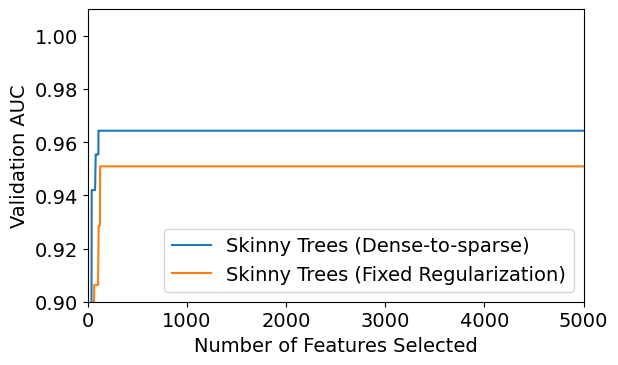

In [11]:
data = 'smk'
budget = 1.0
sparsities = ['GroupL0L2', 'GroupL0L2']
annealing = [True, False]
learning_rate_scheduling = [False, False]
criteria = 'auc'
tuning_seeds = [0,1,2,3]

dfs = {}
for sparsity, anneal, lr_schedule in zip(sparsities, annealing, learning_rate_scheduling):
    print("=============Sparsity:{}, ======== Anneal:{} ====== LR Schedule:{}".format(sparsity, anneal, lr_schedule))

    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
        path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/20.{}/study-shared-sigmoid-{}".format(data, sparsity, tuning_seed, sparsity)
        if anneal:
            path = path+"-anneal"
        if lr_schedule:
            path = path+"-learning_rate_scheduling"
        path = path+"-seed8.csv"
        try:
            df_temp = pd.read_csv(path)
        except:
            print("Missing:", path)
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))
#     df = df[df["user_attrs_feature_sparsity"]<=budget*df["user_attrs_feature_sparsity"].max()]        
    print("Number of trials:", df.shape[0])
#     df = df.groupby("user_attrs_feature_sparsity").agg({"user_attrs_"+criteria+"_valid":'max'})[["user_attrs_"+criteria+"_valid", "user_attrs_"+criteria+"_test"]].reset_index()    
#     df = df[df["user_attrs_"+criteria+"_valid"]>0.9*df["user_attrs_"+criteria+"_valid"].max()]
    
    df = df.sort_values(by=['user_attrs_feature_sparsity', "user_attrs_"+criteria+"_valid"], ascending=[True, False])
    df = df.drop_duplicates('user_attrs_feature_sparsity')
    df = df[['user_attrs_feature_sparsity', "user_attrs_"+criteria+"_valid", "user_attrs_"+criteria+"_test"]]
#     df = df.rolling(window=3).mean()
    df["user_attrs_"+criteria+"_valid_max"] = df["user_attrs_"+criteria+"_valid"].cummax()
    df['test_auc'] = df["user_attrs_"+criteria+"_valid"]
    df = df.merge(df.groupby("user_attrs_"+criteria+"_valid_max")[['test_auc']].first().reset_index(), on="user_attrs_"+criteria+"_valid_max")
    df.rename(columns={'test_auc_y': 'max_test_auc'}, inplace=True)
    
#     break
#     df["user_attrs_"+criteria+"_valid_max"] = df["user_attrs_"+criteria+"_valid"].cummax()
#     df['test_auc'] = df["user_attrs_"+criteria+"_test"]
#     df = df.merge(df.groupby('cummax')[['test_auc']].first().reset_index(), on='cummax')
#     df.rename(columns={'test_auc_y': 'max_test_auc'}, inplace=True)
#     df.index=df.test_auc_x.values
    key = "Sparsity:{}, Anneal:{}, LR-Schedule:{}".format(sparsity, anneal, lr_schedule)
    print(key)
    if key == "Sparsity:GroupL0L2, Anneal:True, LR-Schedule:False":
        key = "Skinny Trees (Dense-to-sparse)"
    elif key == "Sparsity:GroupL0L2, Anneal:False, LR-Schedule:False":    
        key = "Skinny Trees (Fixed Regularization)"
    dfs[key] = df
#     print(dfs.keys())

font = {'size': 14}
plt.rc('font', **font)
plt.figure(figsize=(6.4,3.8))
markers = [".", "*"]
for i, (key, df) in enumerate(dfs.items()):
    plt.plot(df["user_attrs_feature_sparsity"], df['max_test_auc'], label=key)
plt.legend(loc='lower right')
plt.ylabel("Validation AUC")
plt.xlabel("Number of Features Selected")
plt.xlim(0,5000)
plt.ylim(0.9,1.01)
plt.savefig(f"./Figures/sparsity_path_{data}.pdf", bbox_inches='tight')
plt.show()

In [249]:
df

Unnamed: 0  number     value              datetime_start  \
14          14      14  0.500000  2023-10-06 11:59:51.765314   
81           5       5  0.920139  2023-10-06 11:55:32.714374   
..         ...     ...       ...                         ...   
91          15      15       NaN  2023-10-06 14:06:06.138084   
2            2       2       NaN  2023-10-06 10:04:33.677377   

             datetime_complete                duration  \
14  2023-10-06 12:04:11.729341  0 days 00:04:19.964027   
81  2023-10-06 11:55:40.219475  0 days 00:00:07.505101   
..                         ...                     ...   
91  2023-10-06 14:06:39.001956  0 days 00:00:32.863872   
2   2023-10-06 10:08:40.194059  0 days 00:04:06.516682   

    params_batch_size_scaler  params_constant_learning_rate  params_depth  \
14                         1                       2.621694             1   
81                        64                       0.165510             2   
..                       ...                            ...           ...   
91                        64                       0.014344             1   
2                          1                       0.022637             1   

    params_epochs  ...     user_attrs_approximate_weight_sparsity_history  \
14            920  ...  [38183.50704225352, 48461.69014084507, 51256.3...   
81             70  ...  [98649.0, 98089.22222222222, 94875.11111111111...   
..            ...  ...                                                ...   
91            400  ...  [98722.85714285713, 98719.99999999999, 98719.0...   
2             945  ...  [98704.5625, 98700.515625, 98698.34375, 98696....   

    user_attrs_auc_test  user_attrs_auc_valid  user_attrs_feature_sparsity  \
14             0.500000              0.500000                            0   
81             0.849218              0.920139                           97   
..                  ...                   ...                          ...   
91                  NaN                   NaN                        99998   
2                   NaN                   NaN                       100000   

                  user_attrs_feature_sparsity_history  user_attrs_num_epochs  \
14  [42440, 61674, 65953, 62421, 59159, 56026, 594...                    920   
81  [99983, 99480, 96227, 85793, 64670, 38023, 161...                     70   
..                                                ...                    ...   
91  [100000, 100000, 100000, 100000, 100000, 10000...                    400   
2   [100000, 100000, 100000, 100000, 100000, 10000...                    945   

                          user_attrs_val_loss_history  \
14  [5.861533164978027, 23.8145809173584, 14.10126...   
81  [2.2300007343292236, 2.0640034675598145, 1.904...   
..                                                ...   
91  [0.651081383228302, 0.6414209604263306, 0.6325...   
2   [0.36411407589912415, 0.3352678120136261, 0.31...   

    user_attrs_weight_sparsity  \
14                         0.0   
81                        97.0   
..                         ...   
91                     99998.0   
2                     100000.0   

                   user_attrs_weight_sparsity_history     state  
14  [41756.71830985915, 60201.70422535211, 64821.6...  COMPLETE  
81  [99983.0, 99480.0, 96227.0, 85793.0, 64670.0, ...  COMPLETE  
..                                                ...       ...  
91  [100000.0, 100000.0, 100000.0, 100000.0, 10000...      FAIL  
2   [100000.0, 100000.0, 100000.0, 100000.0, 10000...      FAIL  

[62 rows x 28 columns]

In [220]:
df['test_auc']

166    0.5
14     0.5
      ... 
114    NaN
85     NaN
Name: test_auc, Length: 171, dtype: float64

In [225]:
df.groupby("user_attrs_"+criteria+"_valid_max")[['test_auc']].first()

test_auc
user_attrs_auc_valid_max          
0.500000                  0.500000
0.920139                  0.849218
...                            ...
0.978733                  0.909531
0.980035                  0.910555

[11 rows x 1 columns]

In [228]:
df['max_test_auc']

0     0.500000
1     0.500000
        ...   
49    0.910555
50    0.910555
Name: max_test_auc, Length: 51, dtype: float64

In [124]:
dfs.keys()

dict_keys(['Sparsity:GroupL0L2, Anneal:True, LR-Schedule:False', 'Sparsity:none, Anneal:False, LR-Schedule:False'])

In [ ]:
criteria = 'aucs'
tuning_seeds = [0]

df = pd.DataFrame()
for tuning_seed in tuning_seeds:
    path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/20.{}/study-shared-sigmoid-{}".format(data, tuning_seed)
    path = path+"-seed8.csv"
    try:
        df_temp = pd.read_csv(path)
    except:
        print("Missing:", path)
        continue
    df = pd.concat([df,df_temp],axis=0)
    df.index = np.arange(len(df))
df = df[df["user_attrs_feature_sparsities"]<budget*df["user_attrs_feature_sparsities"].max()]
print("Number of trials satisfying the feature sparsity budget:", df.shape[0])

df = df.groupby("user_attrs_feature_sparsities").agg({"user_attrs_"+criteria+"_valid":'max'})[["user_attrs_"+criteria+"_valid"]].reset_index()    
df = df[df["user_attrs_"+criteria+"_valid"]>0.9*df["user_attrs_"+criteria+"_valid"].max()]
df = df.rolling(window=3).mean()
dfs["LassoNet"] = df

In [ ]:
dfs.keys()

In [ ]:
plt.figure(figsize=(6,6))
key_groupl0l2 = 'Sparsity:GroupL0L2, Anneal:True, LR-Schedule:False'
key_lassonet = 'LassoNet'
plt.scatter(dfs[key_groupl0l2]["user_attrs_feature_sparsity"], dfs[key_groupl0l2]["user_attrs_auc_valid"], label="Group L0-L2", marker="*", color='b')
plt.scatter(dfs[key_lassonet]["user_attrs_feature_sparsities"], dfs[key_lassonet]["user_attrs_aucs_valid"], label=key_lassonet, marker="o", color='orange')
plt.legend(loc="lower right")
plt.xlabel("feature selection")
plt.ylabel("Validation-AUC")
plt.ylim(0.90,1.0)
plt.xlim(0,100)

# Averages and Standard Errors

In [4]:
data = 'dorothea'
sparsities = ['GroupL0L2']
annealing = [True]
learning_rate_scheduling = [False]
criteria = 'auc'
tuning_seeds = [100,101,102,103]
# 5 corresponds to no early stopping and 6 corresponds to early stopping

for sparsity, anneal, lr_schedule in zip(sparsities, annealing, learning_rate_scheduling):
    print("=============Sparsity:{}, ======== Anneal:{} ====== LR Schedule:{}".format(sparsity, anneal, lr_schedule))

    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
        path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/5.{}/study-shared-sigmoid-{}".format(data, sparsity, tuning_seed, sparsity)
        if anneal:
            path = path+"-anneal"
        if lr_schedule:
            path = path+"-learning_rate_scheduling"
        path = path+"-seed8.csv"
        try:
            df_temp = pd.read_csv(path)
        except:
            print("Missing:", path)
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))
    print("Number of total trials:", df.shape[0])
#     df = df[(df["user_attrs_feature_sparsity"]<budget*df["user_attrs_feature_sparsity"].max())&(df["user_attrs_feature_sparsity"]>0)]
    print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
    df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
    
#     best_value = df["user_attrs_"+criteria+"_valid"].values[0]
#     df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]
    
    df_opt = df.sort_values(by='user_attrs_feature_sparsity')
#     display(df_opt.T)
    if criteria=='auc':
        print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
        print("test_auc:", df_opt.user_attrs_auc_test.mean())
        print("test_aucs:", df_opt.user_attrs_auc_test.values)
        print("test_aucs (SE):", df_opt.user_attrs_auc_test.sem())
    elif criteria=='accuracy':
        print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
        print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
        print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
    print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
    print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
    print("Standard Error sparsity:", df_opt.user_attrs_approximate_feature_sparsity.std()/np.sqrt(50))
#     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
#     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
#     print("Batch-sizes:", df_opt.params_constant_batch_size.values*df_opt.params_batch_size_scaler.values)
#     print("Epochs:", df_opt.user_attrs_num_epochs.values)
#     print("Number of Trees:", df_opt.params_num_trees.values)
        
#     df = df[df["user_attrs_approximate_feature_sparsity"]<budget*df["user_attrs_approximate_feature_sparsity"].max()]
#     print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
#     df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
#     best_value = df["user_attrs_"+criteria+"_valid"].values[0]
#     df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]

#     df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
#     if criteria=='auc':
#         print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
#         print("test_auc:", df_opt.user_attrs_auc_test.mean())
#         print("test_aucs:", df_opt.user_attrs_auc_test.values)
#     elif criteria=='accuracy':
#         print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
#         print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
#         print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
#     print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
#     print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
# #     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
# #     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
# #     print("Batch-sizes:", df_opt.params_batch_size.values)
#     print("Depths:", df_opt.params_depth.values)
#     print("Epochs:", df_opt.user_attrs_num_epochs.values)
# #     print("Learning Rates:", df_opt.params_learning_rate.values)


=============Sparsity:GroupL0L2, ======== Anneal:True ====== LR Schedule:False
Missing: ./logs/soft_trees/publicdata/dorothea/GroupL0L2/cross-entropy/5.102/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Missing: ./logs/soft_trees/publicdata/dorothea/GroupL0L2/cross-entropy/5.103/study-shared-sigmoid-GroupL0L2-anneal-seed8.csv
Number of total trials: 100
Number of trials satisfying the feature sparsity budget: 100
valid_auc: 0.9786024305555556
test_auc: 0.9086950856291884
test_aucs: [0.9106478  0.91120625 0.91036858 0.90925168 0.91129933 0.90906552
 0.91083395 0.90971705 0.9091586  0.9099032  0.91018243 0.91288161
 0.9095309  0.91083395 0.9087863  0.9099032  0.90999628 0.9091586
 0.91195086 0.91129933 0.90981013 0.90925168 0.908414   0.90962398
 0.90897245 0.90822785 0.91129933 0.90887937 0.90850707 0.90925168
 0.90850707 0.90860015 0.90925168 0.90962398 0.90999628 0.90981013
 0.90999628 0.90813477 0.90971705 0.91055473 0.908414   0.90832092
 0.9095309  0.90822785 0.91018243 0.90832092

In [6]:
pd.to_timedelta(df['duration']).mean()

Timedelta('0 days 00:02:27.581568020')

In [357]:
# df_opt = df_opt.sort_values(by=['user_attrs_feature_sparsity'])

In [358]:
val_loss_history = df_opt.user_attrs_val_loss_history.str.rsplit(pat='[', expand=True)[1].str.rsplit(pat=']', expand=True)[0].str.split(',', expand=True).astype(float).mean(axis=0)
feature_sparsity_history = df_opt.user_attrs_feature_sparsity_history.str.rsplit(pat='[', expand=True)[1].str.rsplit(pat=']', expand=True)[0].str.split(',', expand=True).astype(float).mean(axis=0)


In [359]:
# val_loss_history = [float(i) for i in df_opt['user_attrs_val_loss_history'].values[3][1:-1].split(', ')]
# feature_sparsity_history = [float(i) for i in df_opt['user_attrs_feature_sparsity_history'].values[3][1:-1].split(', ')]

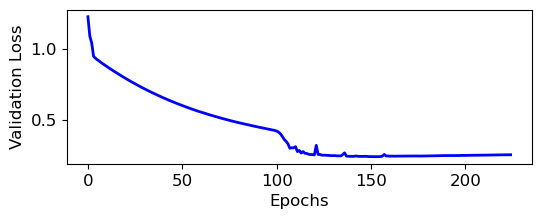

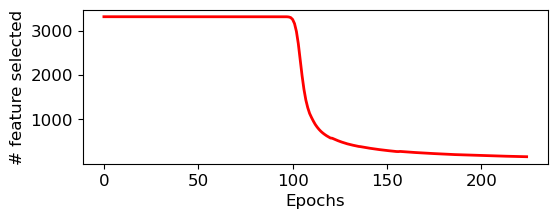

In [360]:
font = {'size': 12}

plt.rc('font', **font)
plt.figure(figsize=(6,2))
plt.plot(val_loss_history, color='b', linewidth=2)
plt.ylabel("Validation Loss")
plt.xlabel("Epochs")
plt.savefig(f"./Figures/Validation_loss_trajectory_{data}.pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(6,2))
plt.plot(feature_sparsity_history, color='r', linewidth=2)
# plt.ylim([0,2000])
plt.ylabel("# feature selected")
plt.xlabel("Epochs")
plt.savefig(f"./Figures/Sparsity_trajectory_{data}.pdf", bbox_inches='tight')
plt.show()


In [99]:
df_opt.user_attrs_num_epochs.values

array([303, 212, 216, 189, 175, 142, 142, 141, 134, 131, 129, 130, 128,
       126, 134, 144, 126, 129, 124, 119, 119, 116, 151, 116, 121])

In [93]:
df_opt[['user_attrs_feature_sparsity', 'user_attrs_num_epochs']]

user_attrs_feature_sparsity  user_attrs_num_epochs
2                           13                    265
1                           18                    283
0                           18                    279

In [53]:
df.value.isna().sum()

0

# Single Tree

In [ ]:
data = 'churn'
budget = 0.5
sparsities = ['GroupL0L2']
annealing = [True]
learning_rate_scheduling = [True]
criteria = 'auc'
tuning_seeds = [0]

for sparsity, anneal, lr_schedule in zip(sparsities, annealing, learning_rate_scheduling):
    print("=============Sparsity:{}, ======== Anneal:{} ====== LR Schedule:{}".format(sparsity, anneal, lr_schedule))

    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
        path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/6.{}/study-shared-sigmoid-1-10-{}".format(data, sparsity, tuning_seed, sparsity)
        if anneal:
            path = path+"-anneal"
        if lr_schedule:
            path = path+"-learning_rate_scheduling"
        path = path+"-seed8.csv"
        try:
            df_temp = pd.read_csv(path)
        except:
            print("Missing:", path)
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))
    print("Number of total trials:", df.shape[0])
    df = df[(df["user_attrs_feature_sparsity"]<=budget*df["user_attrs_feature_sparsity"].max())&(df["user_attrs_feature_sparsity"]>0)]
    print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
    df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
    df = df[df['params_depth']<=9]
    
    best_value = df["user_attrs_"+criteria+"_valid"].values[0]
    df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]
    
    df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
    display(df_opt.T)
    if criteria=='auc':
        print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
        print("test_auc:", df_opt.user_attrs_auc_test.mean())
        print("test_aucs:", df_opt.user_attrs_auc_test.values)
        print("test_aucs (SE):", df_opt.user_attrs_auc_test.std()/np.sqrt(50))
    elif criteria=='accuracy':
        print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
        print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
        print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
    print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
    print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
    print("Standard Error sparsity:", df_opt.user_attrs_approximate_feature_sparsity.std()/np.sqrt(50))
#     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
#     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
    print("Batch-sizes:", df_opt.params_constant_batch_size.values*df_opt.params_batch_size_scaler.values)
    print("Epochs:", df_opt.user_attrs_num_epochs.values)
    print("Number of Trees:", df_opt.params_num_trees.values)
    print("Depths:", df_opt.params_depth.values)
        
#     df = df[df["user_attrs_approximate_feature_sparsity"]<budget*df["user_attrs_approximate_feature_sparsity"].max()]
#     print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
#     df = df.sort_values(by=["user_attrs_"+criteria+"_valid"], ascending=False)
#     best_value = df["user_attrs_"+criteria+"_valid"].values[0]
#     df_opt = df[df["user_attrs_"+criteria+"_valid"]==best_value]

#     df_opt = df_opt.sort_values(by='user_attrs_feature_sparsity')
#     if criteria=='auc':
#         print("valid_auc:", df_opt.user_attrs_auc_valid.mean())
#         print("test_auc:", df_opt.user_attrs_auc_test.mean())
#         print("test_aucs:", df_opt.user_attrs_auc_test.values)
#     elif criteria=='accuracy':
#         print("valid_accuracy:", df_opt.user_attrs_accuracy_valid.mean())
#         print("test_accuracy:", df_opt.user_attrs_accuracy_test.mean())
#         print("test_accuracies:", df_opt.user_attrs_accuracy_test.values)
#     print("sparsity:", df_opt.user_attrs_feature_sparsity.values)
#     print("Mean sparsity:", df_opt.user_attrs_approximate_feature_sparsity.mean())
# #     print("Approx sparsity:", df_opt.user_attrs_approximate_feature_sparsity.values)
# #     print("Mean approx sparsity:", df_opt.user_attrs_feature_sparsity.mean())
# #     print("Batch-sizes:", df_opt.params_batch_size.values)
#     print("Depths:", df_opt.params_depth.values)
#     print("Epochs:", df_opt.user_attrs_num_epochs.values)
# #     print("Learning Rates:", df_opt.params_learning_rate.values)


# Effect of Batch-size 

=============Sparsity:GroupL0L2, ======== Anneal:False ====== LR Schedule:False
Missing: ./logs/soft_trees/publicdata/gisette/GroupL0L2/cross-entropy/59.0/study-shared-sigmoid-GroupL0L2-seed8.csv
Missing: ./logs/soft_trees/publicdata/gisette/GroupL0L2/cross-entropy/59.1/study-shared-sigmoid-GroupL0L2-seed8.csv
Missing: ./logs/soft_trees/publicdata/gisette/GroupL0L2/cross-entropy/59.2/study-shared-sigmoid-GroupL0L2-seed8.csv
Missing: ./logs/soft_trees/publicdata/gisette/GroupL0L2/cross-entropy/59.8/study-shared-sigmoid-GroupL0L2-seed8.csv
Missing: ./logs/soft_trees/publicdata/gisette/GroupL0L2/cross-entropy/59.9/study-shared-sigmoid-GroupL0L2-seed8.csv
Missing: ./logs/soft_trees/publicdata/gisette/GroupL0L2/cross-entropy/59.10/study-shared-sigmoid-GroupL0L2-seed8.csv
Missing: ./logs/soft_trees/publicdata/gisette/GroupL0L2/cross-entropy/59.11/study-shared-sigmoid-GroupL0L2-seed8.csv
Missing: ./logs/soft_trees/publicdata/gisette/GroupL0L2/cross-entropy/59.12/study-shared-sigmoid-GroupL0L2

(0.9, 1.0)

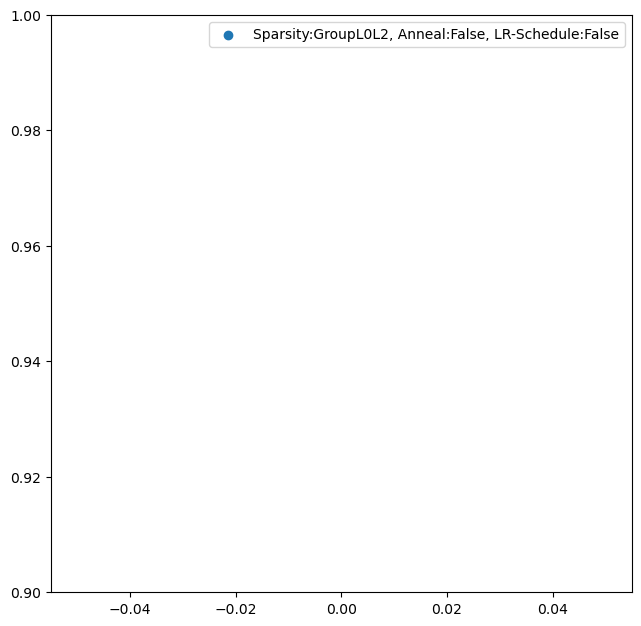

In [131]:
data = 'gisette'
budget = 1.0
sparsities = ['GroupL0L2']
annealing = [False]
learning_rate_scheduling = [False]
criteria = 'auc'
tuning_seeds = np.arange(32)

dfs = {}
for sparsity, anneal, lr_schedule in zip(sparsities, annealing, learning_rate_scheduling):
    print("=============Sparsity:{}, ======== Anneal:{} ====== LR Schedule:{}".format(sparsity, anneal, lr_schedule))

    df = pd.DataFrame()
    for tuning_seed in tuning_seeds:
        path = "./logs/soft_trees/publicdata/{}/{}/cross-entropy/59.{}/study-shared-sigmoid-{}".format(data, sparsity, tuning_seed, sparsity)
        if anneal:
            path = path+"-anneal"
        if lr_schedule:
            path = path+"-learning_rate_scheduling"
        path = path+"-seed8.csv"
        try:
            df_temp = pd.read_csv(path)
        except:
            print("Missing:", path)
            continue
        df = pd.concat([df,df_temp],axis=0)
        df.index = np.arange(len(df))
    max_features = df["user_attrs_feature_sparsity"].max()
    print("Number of total trials:", df.shape[0])
#     df = df[df["user_attrs_feature_sparsity"]<budget*df["user_attrs_feature_sparsity"].max()]        
#     df = df[df["user_attrs_feature_sparsity"]>0]        
    print("Number of trials satisfying the feature sparsity budget:", df.shape[0])
#     df = df.groupby("user_attrs_feature_sparsity").agg({"user_attrs_"+criteria+"_valid":'max'})[["user_attrs_"+criteria+"_valid"]].reset_index()    
#     df = df[df["user_attrs_"+criteria+"_valid"]>0.9*df["user_attrs_"+criteria+"_valid"].max()]
#     df = df.sort_values(by="user_attrs_feature_sparsity")
#     df = df.cummax(axis=0).reset_index()
    dfs["Sparsity:{}, Anneal:{}, LR-Schedule:{}".format(sparsity, anneal, lr_schedule)] = df
    
plt.figure(figsize=(7.5,7.5))
markers = ["o", "*"]
for i, (key, df) in enumerate(dfs.items()):
    plt.scatter(df["user_attrs_feature_sparsity"], df["user_attrs_"+criteria+"_valid"], label=key, marker=markers[i])
plt.legend()
plt.ylim(0.9,1.0)

In [132]:
df.columns

Index(['Unnamed: 0', 'number', 'value', 'datetime_start', 'datetime_complete',
       'duration', 'params_batch_size_scaler', 'params_constant_learning_rate',
       'params_depth', 'params_epochs', 'params_kernel_constraint',
       'params_kernel_l2', 'params_num_trees', 'user_attrs_accuracy_test',
       'user_attrs_accuracy_valid', 'user_attrs_approximate_feature_sparsity',
       'user_attrs_approximate_feature_sparsity_history',
       'user_attrs_approximate_weight_sparsity',
       'user_attrs_approximate_weight_sparsity_history', 'user_attrs_auc_test',
       'user_attrs_auc_valid', 'user_attrs_feature_sparsity',
       'user_attrs_feature_sparsity_history', 'user_attrs_num_epochs',
       'user_attrs_val_loss_history', 'user_attrs_weight_sparsity',
       'user_attrs_weight_sparsity_history', 'state'],
      dtype='object')

In [133]:
df['params_kernel_constraint'].sort_values()

0     50.0
62    50.0
      ... 
31    50.0
86    50.0
Name: params_kernel_constraint, Length: 87, dtype: float64

In [134]:
df['params_batch_size'] = df['params_batch_size_scaler']*16

In [135]:
df.columns

Index(['Unnamed: 0', 'number', 'value', 'datetime_start', 'datetime_complete',
       'duration', 'params_batch_size_scaler', 'params_constant_learning_rate',
       'params_depth', 'params_epochs', 'params_kernel_constraint',
       'params_kernel_l2', 'params_num_trees', 'user_attrs_accuracy_test',
       'user_attrs_accuracy_valid', 'user_attrs_approximate_feature_sparsity',
       'user_attrs_approximate_feature_sparsity_history',
       'user_attrs_approximate_weight_sparsity',
       'user_attrs_approximate_weight_sparsity_history', 'user_attrs_auc_test',
       'user_attrs_auc_valid', 'user_attrs_feature_sparsity',
       'user_attrs_feature_sparsity_history', 'user_attrs_num_epochs',
       'user_attrs_val_loss_history', 'user_attrs_weight_sparsity',
       'user_attrs_weight_sparsity_history', 'state', 'params_batch_size'],
      dtype='object')

In [136]:
df = df[['params_batch_size', "user_attrs_feature_sparsity", "user_attrs_"+criteria+"_valid", 'params_depth', 'params_num_trees', 'params_epochs', 'user_attrs_num_epochs']]

In [137]:
df

params_batch_size  user_attrs_feature_sparsity  user_attrs_auc_valid  \
0                 496                         5000                   NaN   
1                 640                         5000                   NaN   
..                ...                          ...                   ...   
85                144                         5000                   NaN   
86                880                         5000                   NaN   

    params_depth  params_num_trees  params_epochs  user_attrs_num_epochs  
0              3                50           1550                   1550  
1              3                50           2000                   2000  
..           ...               ...            ...                    ...  
85             3                50            450                    450  
86             3                50           2750                   2750  

[87 rows x 7 columns]

In [138]:
df["max_auc_valid"] = np.zeros(df.shape[0])

/state/partition1/slurm_tmp/23960892.0.0/ipykernel_796525/4058380591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["max_auc_valid"] = np.zeros(df.shape[0])


In [139]:
df

params_batch_size  user_attrs_feature_sparsity  user_attrs_auc_valid  \
0                 496                         5000                   NaN   
1                 640                         5000                   NaN   
..                ...                          ...                   ...   
85                144                         5000                   NaN   
86                880                         5000                   NaN   

    params_depth  params_num_trees  params_epochs  user_attrs_num_epochs  \
0              3                50           1550                   1550   
1              3                50           2000                   2000   
..           ...               ...            ...                    ...   
85             3                50            450                    450   
86             3                50           2750                   2750   

    max_auc_valid  
0             0.0  
1             0.0  
..            ...  
85            0.0  
86            0.0  

[87 rows x 8 columns]

In [140]:
df = df.sort_values(by="params_batch_size")

In [141]:
df

params_batch_size  user_attrs_feature_sparsity  user_attrs_auc_valid  \
42                 16                         5000                   NaN   
7                  16                         5000                   NaN   
..                ...                          ...                   ...   
13               1008                         5000                   NaN   
73               1024                         5000                   NaN   

    params_depth  params_num_trees  params_epochs  user_attrs_num_epochs  \
42             3                50             50                     50   
7              3                50             50                     50   
..           ...               ...            ...                    ...   
13             3                50           3150                   3150   
73             3                50           3200                   3200   

    max_auc_valid  
42            0.0  
7             0.0  
..            ...  
13            0.0  
73            0.0  

[87 rows x 8 columns]

In [142]:
# for i, (index, row) in enumerate(df.iterrows()):
#     max_auc_valid = df[df['user_attrs_feature_sparsity']==row["user_attrs_feature_sparsity"]].user_attrs_auc_valid.max()
# #     print(i, index, max_auc_valid)
#     df.loc[index, "max_auc_valid"] = max_auc_valid

In [143]:
# df = df.sort_values(by=['user_attrs_feature_sparsity', 'max_auc_valid'], ascending=[True, True]).drop_duplicates(subset=['user_attrs_feature_sparsity'])

In [144]:
df

params_batch_size  user_attrs_feature_sparsity  user_attrs_auc_valid  \
42                 16                         5000                   NaN   
7                  16                         5000                   NaN   
..                ...                          ...                   ...   
13               1008                         5000                   NaN   
73               1024                         5000                   NaN   

    params_depth  params_num_trees  params_epochs  user_attrs_num_epochs  \
42             3                50             50                     50   
7              3                50             50                     50   
..           ...               ...            ...                    ...   
13             3                50           3150                   3150   
73             3                50           3200                   3200   

    max_auc_valid  
42            0.0  
7             0.0  
..            ...  
13            0.0  
73            0.0  

[87 rows x 8 columns]

In [145]:
df = df.sort_values(by='params_batch_size')
df

params_batch_size  user_attrs_feature_sparsity  user_attrs_auc_valid  \
42                 16                         5000                   NaN   
7                  16                         5000                   NaN   
..                ...                          ...                   ...   
28               1008                         5000                   NaN   
73               1024                         5000                   NaN   

    params_depth  params_num_trees  params_epochs  user_attrs_num_epochs  \
42             3                50             50                     50   
7              3                50             50                     50   
..           ...               ...            ...                    ...   
28             3                50           3150                   3150   
73             3                50           3200                   3200   

    max_auc_valid  
42            0.0  
7             0.0  
..            ...  
28            0.0  
73            0.0  

[87 rows x 8 columns]

In [146]:
df.params_batch_size.values

array([  16,   16,   32,   48,   48,   80,   96,   96,  112,  112,  144,
        144,  160,  160,  192,  208,  224,  224,  224,  256,  256,  288,
        304,  304,  320,  320,  320,  352,  368,  384,  384,  400,  416,
        416,  432,  448,  448,  448,  448,  464,  464,  464,  480,  480,
        496,  496,  496,  512,  512,  544,  592,  592,  640,  640,  640,
        640,  656,  720,  736,  768,  768,  768,  768,  784,  784,  800,
        832,  864,  864,  880,  880,  880,  896,  896,  912,  912,  928,
        944,  960,  960,  960,  992,  992,  992, 1008, 1008, 1024])

In [147]:
df.user_attrs_num_epochs.values

array([  50,   50,  100,  150,  150,  250,  300,  300,  350,  350,  450,
        450,  500,  500,  600,  650,  700,  700,  700,  800,  800,  900,
        950,  950, 1000, 1000, 1000, 1100, 1150, 1200, 1200, 1250, 1300,
       1300, 1350, 1400, 1400, 1400, 1400, 1450, 1450, 1450, 1500, 1500,
       1550, 1550, 1550, 1600, 1600, 1700, 1850, 1850, 2000, 2000, 2000,
       2000, 2050, 2250, 2300, 2400, 2400, 2400, 2400, 2450, 2450, 2500,
       2600, 2700, 2700, 2750, 2750, 2750, 2800, 2800, 2850, 2850, 2900,
       2950, 3000, 3000, 3000, 3100, 3100, 3100, 3150, 3150, 3200])

In [148]:
df_sparse = df.groupby(["params_batch_size"]).agg({"user_attrs_feature_sparsity":'median'})[["user_attrs_feature_sparsity"]].reset_index()    


In [149]:
df_sparse

params_batch_size  user_attrs_feature_sparsity
0                  16                       5000.0
1                  32                       5000.0
..                ...                          ...
44               1008                       5000.0
45               1024                       5000.0

[46 rows x 2 columns]

In [150]:
# df_sparse = df_sparse[df_sparse["params_depth"]==3]
# df_sparse = df_sparse[(df_sparse["params_num_trees"]>30)&(df_sparse["params_num_trees"]<70)]

In [151]:
df_sparse

params_batch_size  user_attrs_feature_sparsity
0                  16                       5000.0
1                  32                       5000.0
..                ...                          ...
44               1008                       5000.0
45               1024                       5000.0

[46 rows x 2 columns]

In [152]:
df_sparse["params_batch_size"] = np.log2(df_sparse["params_batch_size"])

In [153]:
df_sparse

params_batch_size  user_attrs_feature_sparsity
0             4.00000                       5000.0
1             5.00000                       5000.0
..                ...                          ...
44            9.97728                       5000.0
45           10.00000                       5000.0

[46 rows x 2 columns]

In [154]:
# df_sparse = df_sparse.rolling(1).mean().dropna(axis=0)

In [155]:
df_sparse

params_batch_size  user_attrs_feature_sparsity
0             4.00000                       5000.0
1             5.00000                       5000.0
..                ...                          ...
44            9.97728                       5000.0
45           10.00000                       5000.0

[46 rows x 2 columns]

In [156]:
df_sparse.params_batch_size.values

array([ 4.        ,  5.        ,  5.5849625 ,  6.32192809,  6.5849625 ,
        6.80735492,  7.169925  ,  7.32192809,  7.5849625 ,  7.70043972,
        7.80735492,  8.        ,  8.169925  ,  8.24792751,  8.32192809,
        8.45943162,  8.52356196,  8.5849625 ,  8.64385619,  8.70043972,
        8.7548875 ,  8.80735492,  8.857981  ,  8.9068906 ,  8.95419631,
        9.        ,  9.08746284,  9.20945337,  9.32192809,  9.357552  ,
        9.4918531 ,  9.52356196,  9.5849625 ,  9.61470984,  9.64385619,
        9.70043972,  9.7548875 ,  9.78135971,  9.80735492,  9.83289001,
        9.857981  ,  9.88264305,  9.9068906 ,  9.95419631,  9.97727992,
       10.        ])

In [157]:
from scipy.stats import spearmanr 
spearmanr(df_sparse["params_batch_size"].values, df_sparse["user_attrs_feature_sparsity"].values)

/home/gridsan/shibal/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


SignificanceResult(statistic=nan, pvalue=nan)

In [158]:
spearmanr(2**(df_sparse["params_batch_size"].values), df_sparse["user_attrs_feature_sparsity"].values)

SignificanceResult(statistic=nan, pvalue=nan)

In [283]:
font = {'weight' : 'normal',
        'size'   : 16}

PearsonRResult(statistic=-0.2636688025499189, pvalue=0.17518580551001878)


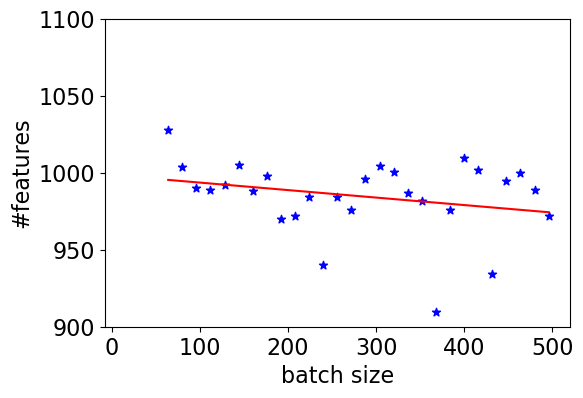

In [292]:
plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(2**(df_sparse["params_batch_size"]), df_sparse["user_attrs_feature_sparsity"], marker="*", color='b')

x = 2**(df_sparse["params_batch_size"])
y = df_sparse["user_attrs_feature_sparsity"]
x = x[y<1100]
y = y[y<1100]

print(pearsonr(x, y))

plt.plot(
    np.unique(x),
    np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
    'r'
)
plt.xlabel("batch size")
plt.ylabel("#features")
ax = plt.gca()
# ax.set_yscale('log')
plt.draw()
plt.savefig("sparsity-vs-batchsize-{}.pdf".format(data+'-new'), bbox_inches='tight')
plt.ylim([900,1100])
plt.show()

In [242]:
x

2      48.0
3      64.0
      ...  
29    480.0
30    496.0
Name: params_batch_size, Length: 29, dtype: float64